In [6]:
import pygmt
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from scipy import stats
from scipy import signal
import obspy
from obspy.geodetics.base import gps2dist_azimuth
import numpy as np

from scipy.signal import hilbert, spectrogram, savgol_filter
from scipy.fft import fft
from tqdm import tqdm 
import seaborn as sns

In [13]:
## Function for tapering
def apply_cosine_taper(arrays, taper_percent=10):
    tapered_arrays = []
    
    #print(arrays.shape)
    num_samples = arrays.shape[1]  # Assuming each sub-array has the same length
    
    for array in arrays:
        

        taper_length = int(num_samples * taper_percent / 100)
        taper_window = np.hanning(2 * taper_length)
        
     
        tapered_array = array.copy()
        tapered_array[:taper_length] = tapered_array[:taper_length] * taper_window[:taper_length]
        tapered_array[-taper_length:] = tapered_array[-taper_length:] * taper_window[taper_length:]
        
        tapered_arrays.append(tapered_array)
    
    return np.array(tapered_arrays)     


# Function for filtering
def butterworth_filter(arrays, lowcut, highcut, fs, num_corners, filter_type='bandpass'):
    """
    Apply a Butterworth filter (bandpass, highpass, or lowpass) to each array in an array of arrays.

    Parameters:
        arrays (list of numpy arrays): List of arrays to be filtered.
        lowcut (float): Lower cutoff frequency in Hz.
        highcut (float): Upper cutoff frequency in Hz.
        fs (float): Sampling frequency in Hz.
        num_corners (int): Number of corners (filter order).
        filter_type (str, optional): Type of filter ('bandpass', 'highpass', or 'lowpass'). Default is 'bandpass'.

    Returns:
        list of numpy arrays: List of filtered arrays.
    """
    filtered_arrays = []
    for data in arrays:
        # Normalize the frequency values to Nyquist frequency (0.5*fs)
        lowcut_norm = lowcut / (0.5 * fs)
        highcut_norm = highcut / (0.5 * fs)

        # Design the Butterworth filter based on the filter type
        if filter_type == 'bandpass':
            b, a = signal.butter(num_corners, [lowcut_norm, highcut_norm], btype='band')
        elif filter_type == 'highpass':
            b, a = signal.butter(num_corners, lowcut_norm, btype='high')
        elif filter_type == 'lowpass':
            b, a = signal.butter(num_corners, highcut_norm, btype='low')
        else:
            raise ValueError("Invalid filter_type. Use 'bandpass', 'highpass', or 'lowpass'.")

        # Apply the filter to the data using lfilter
        filtered_data = signal.lfilter(b, a, data)

        filtered_arrays.append(filtered_data)

    return filtered_arrays

              

In [3]:
# extracting the catalog
comcat_file_csv = pd.read_csv("/data/whd01/yiyu_data/PNWML/comcat_metadata.csv")
exotic_file_csv = pd.read_csv("/data/whd01/yiyu_data/PNWML/exotic_metadata.csv")
noise_file_csv = pd.read_csv("/data/whd01/yiyu_data/PNWML/noise_metadata.csv")



# extracting the metadata corresponding to individual events
cat_exp = comcat_file_csv[comcat_file_csv['source_type'] == 'explosion']
cat_eq = comcat_file_csv[comcat_file_csv['source_type'] == 'earthquake']
cat_no = noise_file_csv
cat_su = exotic_file_csv[exotic_file_csv['source_type'] == 'surface event']

## Creating event location map

/tmp/ipykernel_2219186/731778494.py:14: FutureWarning: The 'color' parameter has been deprecated since v0.8.0 and will be removed in v0.12.0. Please use 'fill' instead.
  fig.plot(x= cat_eq["source_longitude_deg"], y= cat_eq["source_latitude_deg"], style="c0.1c", color="steelblue1", pen="black", label="Earthquakes")
/tmp/ipykernel_2219186/731778494.py:15: FutureWarning: The 'color' parameter has been deprecated since v0.8.0 and will be removed in v0.12.0. Please use 'fill' instead.
  fig.plot(x= cat_exp["source_longitude_deg"], y= cat_exp["source_latitude_deg"], style="c0.1c", color="mediumpurple", pen="black", label = "Explosions")
/tmp/ipykernel_2219186/731778494.py:16: FutureWarning: The 'color' parameter has been deprecated since v0.8.0 and will be removed in v0.12.0. Please use 'fill' instead.
  fig.plot(x= cat_su["station_longitude_deg"], y= cat_su["station_latitude_deg"], style="i0.2c", color="green", pen="black", label = "Surface event stations")


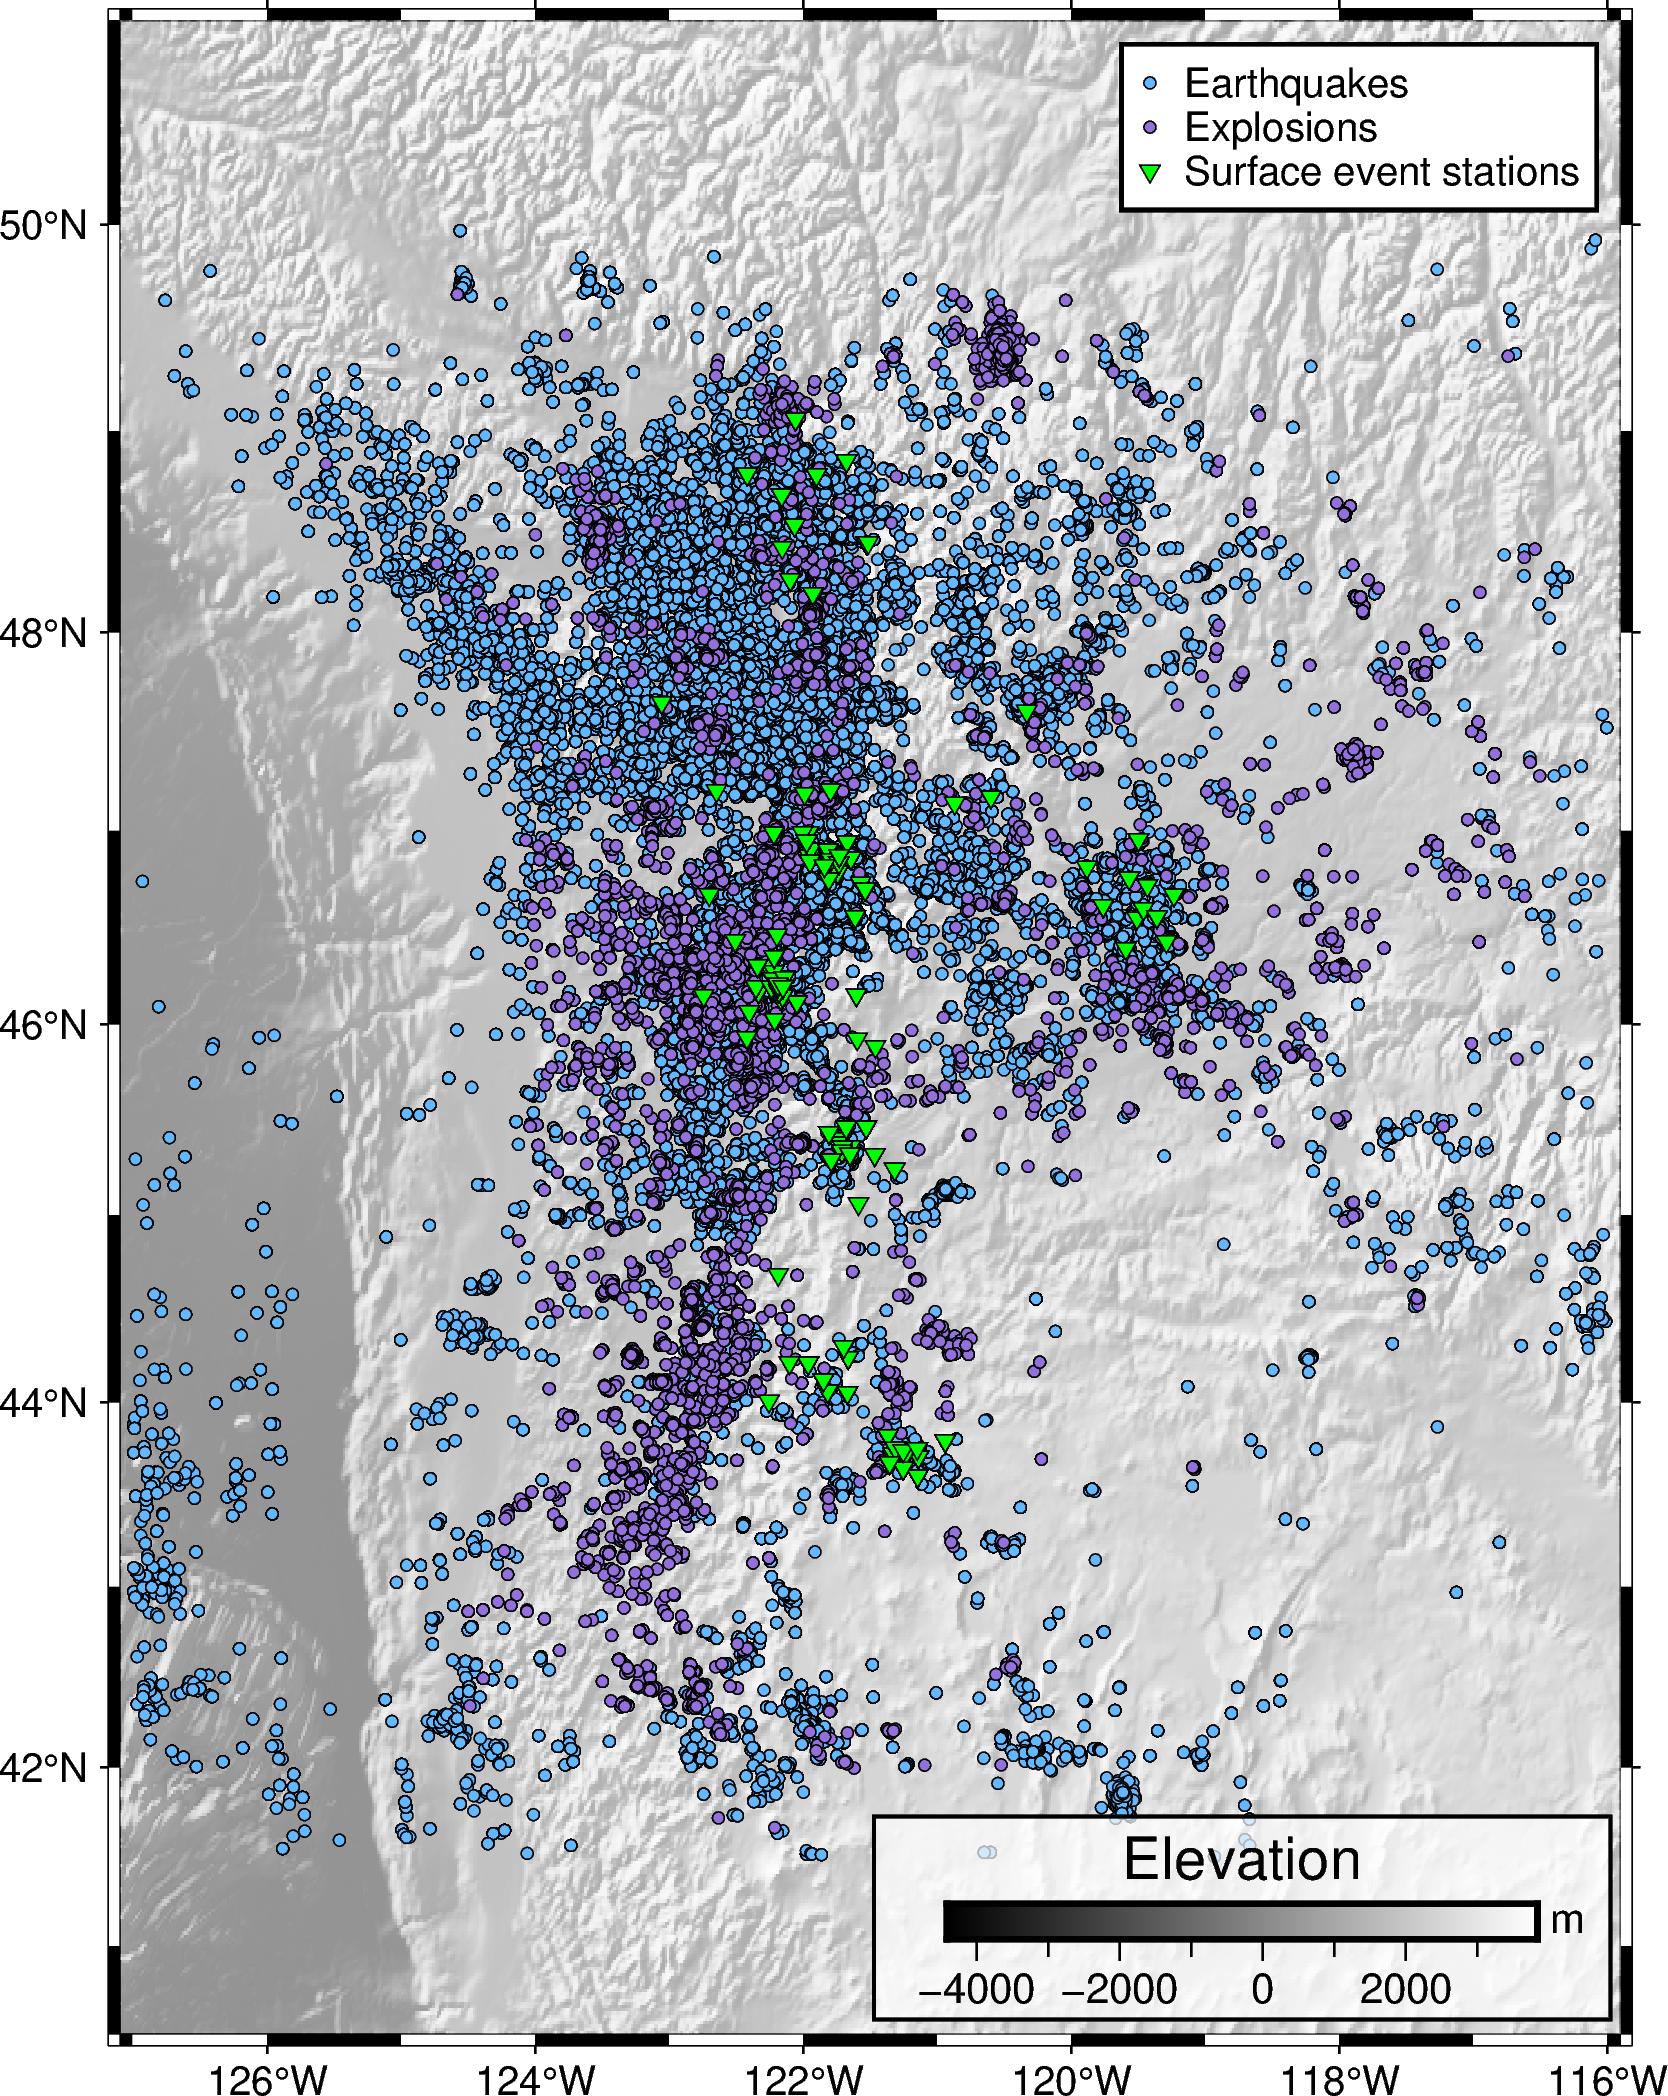

In [8]:
# Create a PyGMT figure
fig = pygmt.Figure()

# Set the region and projection
region = [cat_eq["source_longitude_deg"].min()-0.1, cat_eq["source_longitude_deg"].max()+0.1,
          cat_eq["source_latitude_deg"].min()-1, cat_eq["source_latitude_deg"].max()+1]
projection = "M5i"
fig.basemap(region=region, projection=projection, frame=True)

# Plot the high-resolution topography background
fig.grdimage("@earth_relief_01m", region=region, projection=projection, shading=True, cmap = 'gray', transparency = 50)

# Plot the seismic events
fig.plot(x= cat_eq["source_longitude_deg"], y= cat_eq["source_latitude_deg"], style="c0.1c", color="steelblue1", pen="black", label="Earthquakes")
fig.plot(x= cat_exp["source_longitude_deg"], y= cat_exp["source_latitude_deg"], style="c0.1c", color="mediumpurple", pen="black", label = "Explosions")
fig.plot(x= cat_su["station_longitude_deg"], y= cat_su["station_latitude_deg"], style="i0.2c", color="green", pen="black", label = "Surface event stations")


fig.legend(position="JTR+jTR+o0.2c", box='+gwhite+p1p')

# Add a color scale bar
fig.colorbar(
    
    # Place the colorbar inside the plot (lower-case "j") with justification
    # Bottom Right and an offset ("+o") of 0.7 centimeters and
    # 0.3 centimeters in x or y directions, respectively
    # Move the x label above the horizontal colorbar ("+ml")
    
    projection = projection,
    position="jBR+o0.7c/0.8c+h+w5c/0.3c+ml",
    # Add a box around the colobar with a fill ("+g") in "white" color and
    # a transparency ("@") of 30 % and with a 0.8-points thick black
    # outline ("+p")
    box="+gwhite@30+p0.8p,black",

    # Add x and y labels ("+l")
    frame=["x+lElevation", "y+lm"],
    

    

)

# Add a title
fig.text(x=0, y=0, text="Seismic Events with High-Resolution Topography", font="10p,Helvetica-Bold")

# Save the figure
fig.savefig("seismic_events_map.png", dpi=300)

# Show the figure
fig.show()


In [15]:
import pandas as pd
import numpy as np
import h5py
from tqdm import tqdm
from pathlib import Path

# ------------------------------
# Utility Function to Load Metadata and Extract Data
# ------------------------------
def load_waveform_data(csv_path, hdf5_path, label=None, n_samples=500, waveform_len=15000):
    """
    Load waveform data from HDF5 file based on metadata.

    Args:
        csv_path (str): Path to metadata CSV.
        hdf5_path (str): Path to HDF5 file.
        label (str or None): Filter for 'source_type' if specified.
        n_samples (int): Number of samples to load.
        waveform_len (int): Number of time steps to extract per trace.

    Returns:
        tuple: (data, filtered_metadata)
    """
    # Load metadata
    metadata = pd.read_csv(csv_path)
    if label:
        metadata = metadata[metadata['source_type'] == label]

    trace_names = metadata['trace_name'].values
    buckets = [name.split('$')[0] for name in trace_names]
    indices = [int(name.split('$')[1].split(',')[0]) for name in trace_names]

    # Load waveforms
    data = []
    with h5py.File(hdf5_path, 'r') as f:
        for i in tqdm(range(min(n_samples, len(metadata))), desc=f"Loading {label or 'data'}"):
            data.append(f[f'/data/{buckets[i]}'][indices[i], :, :waveform_len])
    
    return np.array(data), metadata

# ------------------------------
# File Paths
# ------------------------------
base_path = Path("/data/whd01/yiyu_data/PNWML")
file_paths = {
    "noise": {
        "csv": base_path / "noise_metadata.csv",
        "hdf5": base_path / "noise_waveforms.hdf5",
        "waveform_len": 15000
    },
    "comcat": {
        "csv": base_path / "comcat_metadata.csv",
        "hdf5": base_path / "comcat_waveforms.hdf5",
        "waveform_len": 15000
    },
    "exotic": {
        "csv": base_path / "exotic_metadata.csv",
        "hdf5": base_path / "exotic_waveforms.hdf5",
        "waveform_len": 18000
    }
}

# ------------------------------
# Load Noise
# ------------------------------
data_no, metadata_no = load_waveform_data(
    csv_path=file_paths["noise"]["csv"],
    hdf5_path=file_paths["noise"]["hdf5"],
    waveform_len=file_paths["noise"]["waveform_len"]
)

# ------------------------------
# Load Explosions from COMCAT
# ------------------------------
data_exp, metadata_exp = load_waveform_data(
    csv_path=file_paths["comcat"]["csv"],
    hdf5_path=file_paths["comcat"]["hdf5"],
    label="explosion",
    waveform_len=file_paths["comcat"]["waveform_len"]
)

# ------------------------------
# Load Earthquakes from COMCAT
# ------------------------------
data_eq, metadata_eq = load_waveform_data(
    csv_path=file_paths["comcat"]["csv"],
    hdf5_path=file_paths["comcat"]["hdf5"],
    label="earthquake",
    waveform_len=file_paths["comcat"]["waveform_len"]
)

# ------------------------------
# Load Surface Events from Exotic
# ------------------------------
data_su, metadata_su = load_waveform_data(
    csv_path=file_paths["exotic"]["csv"],
    hdf5_path=file_paths["exotic"]["hdf5"],
    label="surface event",
    waveform_len=file_paths["exotic"]["waveform_len"]
)


Loading surface event: 100%|██████████| 500/500 [00:00<00:00, 2870.59it/s]


## Plotting some waveforms from each class 

In [24]:
trace_p_eq = metadata_earthquakes['trace_P_arrival_sample'].values
trace_p_exp = metadata_explosions['trace_P_arrival_sample'].values



tapered_eq = apply_cosine_taper(data_eq[:,2])
filtered_eq = butterworth_filter(tapered_eq,  1, 10, 100, 4)
norm_eq = filtered_eq/np.max(abs(np.array(filtered_eq)), axis = 1).reshape(-1,1)


tapered_no = apply_cosine_taper(np.array(data_no)[:,2])
filtered_no = butterworth_filter(tapered_no, 1, 10, 100, 4)
norm_no = filtered_no/np.max(abs(np.array(filtered_no)), axis = 1).reshape(-1,1)



tapered_exp = apply_cosine_taper(data_exp[:,2])
filtered_exp = butterworth_filter(tapered_exp,  1, 10, 100, 4)
norm_exp = filtered_exp/np.max(abs(np.array(filtered_exp)), axis = 1).reshape(-1,1)


tapered_su = apply_cosine_taper(data_su[:,2])
filtered_su = butterworth_filter(tapered_su,  1, 10, 100, 4)
norm_su = filtered_su/np.max(abs(np.array(filtered_su)), axis = 1).reshape(-1,1)



def plot_event_information(waveform = norm_su[0], xlim = [20, 170], class_name = 'Earthquake'):
    
    # Generate time vector

    
    

    t = np.linspace(0, xlim[1]-xlim[0], (xlim[1] - xlim[0])*100)
    waveform = waveform[int(xlim[0])*100:int(xlim[1])*100]
    
    # Compute Fourier spectrum
    N = len(waveform)  # Length of the signal
    T = t[1] - t[0]  # Sample spacing
    frequencies = np.fft.fftfreq(N, d=T)
    fourier = fft(waveform)

    # Compute spectrogram
    f, t_spec, Sxx = spectrogram(waveform, fs=100, nperseg= 128)

    # Create subplots
    fig, axs = plt.subplots(3, 1, figsize=[8, 9])

    # Plot time series
    axs[0].plot(t, waveform, lw=0.5)
    #axs[0].set_title('Noise')
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Amplitude')
    axs[0].grid(True)
    axs[0].set_xlim(0, xlim[1] - xlim[0])
    # Plot Fourier spectrum
    axs[2].plot(frequencies[:N//2], np.abs(fourier[:N//2]))
    #axs[2].set_title('Fourier Spectrum')
    axs[2].set_xlabel('Frequency (Hz)')
    axs[2].set_ylabel('Amplitude')
    axs[2].grid(True)
    axs[2].set_xlim(0, 15)

    # Plot spectrogram
    img = axs[1].pcolormesh(t_spec, f, np.log(Sxx), cmap='viridis', vmin=-20, vmax=-5)
    axs[1].set_xlim(0, xlim[1] - xlim[0])
    #axs[1].set_title('Spectrogram')
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Frequency (Hz)')
    axs[1].set_ylim(0, 15)  # Adjust frequency range if necessary
    #fig.colorbar(img, ax=axs[2], label='Log Power')

    print(f'Plotting {class_name} waveforms')
    plt.tight_layout()
    plt.show()
    
    

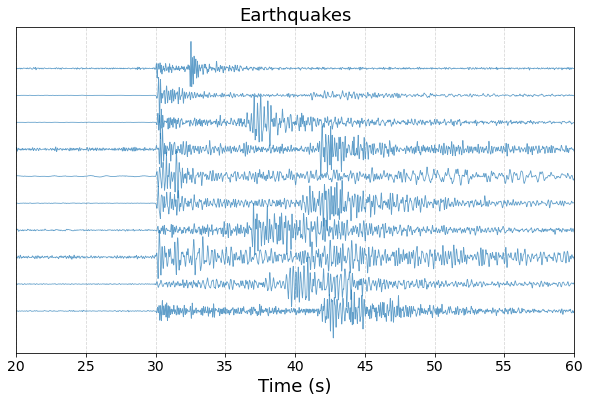

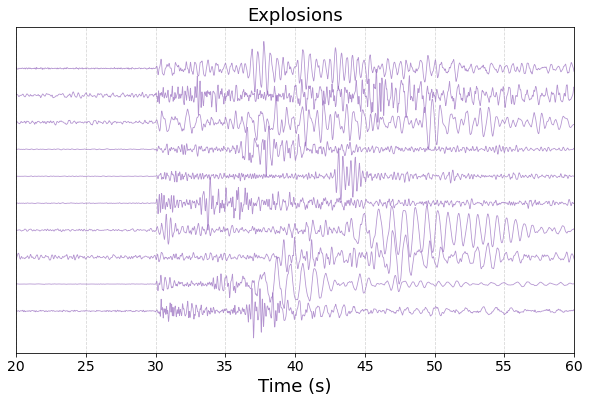

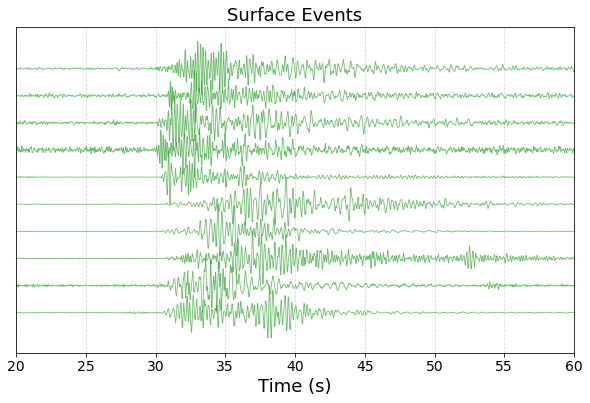

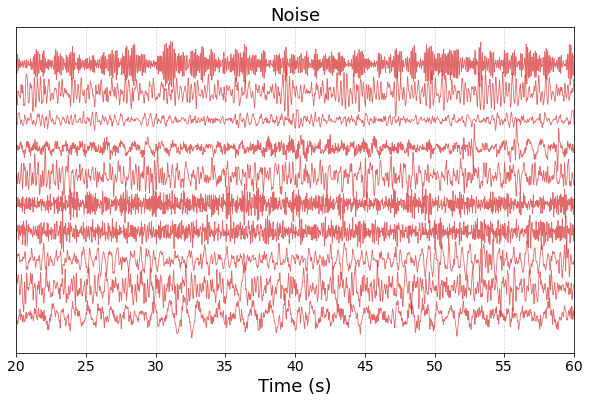

In [23]:
# -----------------------
# Define color scheme
# -----------------------
COLORS = {
    'earthquake': '#1f77b4',  # dark blue
    'explosion': '#9467bd',   # dark purple
    'surface': '#2ca02c',     # dark green
    'noise': '#d62728',       # dark red
}

# -----------------------
# Matplotlib appearance
# -----------------------
plt.rcParams.update({
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'axes.labelsize': 18,
    'axes.titlesize': 18,
})

# -----------------------
# General plotting function
# -----------------------
def plot_waveforms(data, trace_picks, l1, l2, title, color, align_idx=3000, sample_rate=100, origin=None):
    """
    Plots a set of waveforms with vertical offset.
    
    Args:
        data (list or array): 2D list of normalized waveforms.
        trace_picks (list): List of pick indices per trace.
        l1, l2 (int): Range of trace indices to plot.
        title (str): Title of the plot.
        color (str): Hex color for the waveform traces.
        align_idx (int): Number of samples before the pick (for slicing).
        sample_rate (int): Sample rate in Hz.
        origin (int or None): Optional custom alignment index (used in surface/noise).
    """
    plt.figure(figsize=(10, 6))

    for i in range(l1, l2):
        start_idx = (origin if origin is not None else trace_picks[i]) - align_idx
        waveform = data[i][start_idx:]
        t = np.linspace(0, len(waveform) / sample_rate, len(waveform))
        plt.plot(t, waveform + i, lw=0.8, color=color, alpha=0.7)

    plt.yticks([])
    plt.xlim(20, 60)
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

# -----------------------
# Plot all four classes
# -----------------------

plot_waveforms(norm_eq, trace_p_eq, l1=300, l2=310, title='Earthquakes', color=COLORS['earthquake'])

plot_waveforms(norm_exp, trace_p_exp, l1=320, l2=330, title='Explosions', color=COLORS['explosion'])

plot_waveforms(norm_su, None, l1=450, l2=460, title='Surface Events', color=COLORS['surface'], origin=7000)

plot_waveforms(norm_no, None, l1=450, l2=460, title='Noise', color=COLORS['noise'], origin=7000)


## Plotting waveform, spectrogram and fourier transform from each class

Plotting Surface Event waveforms


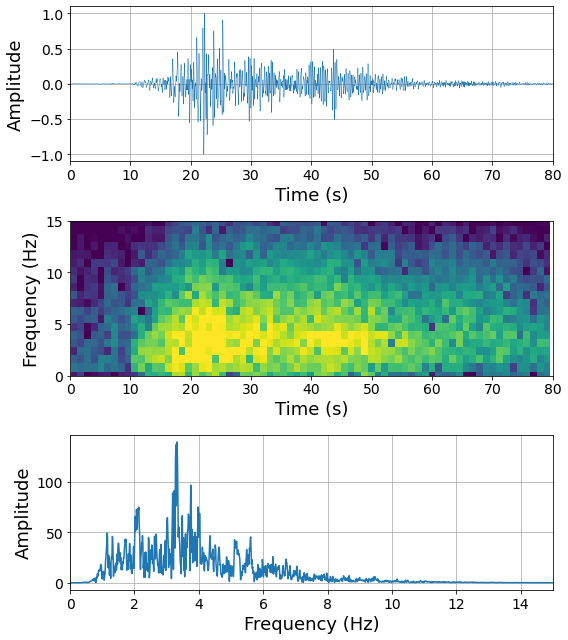

Plotting Noise waveforms


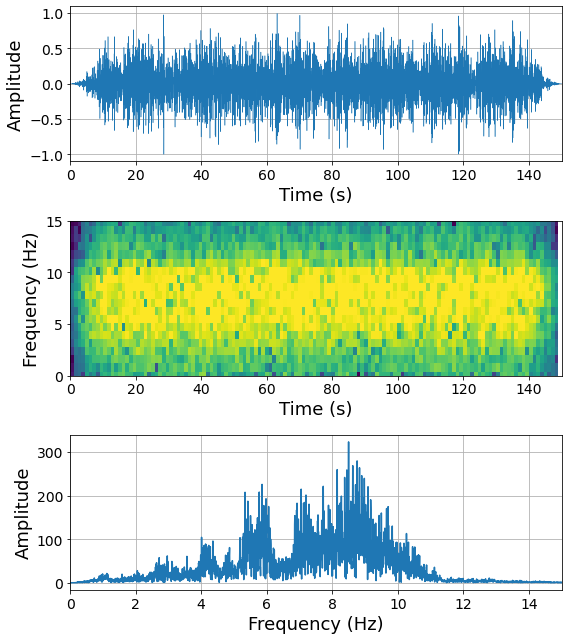

Plotting Earthquake waveforms


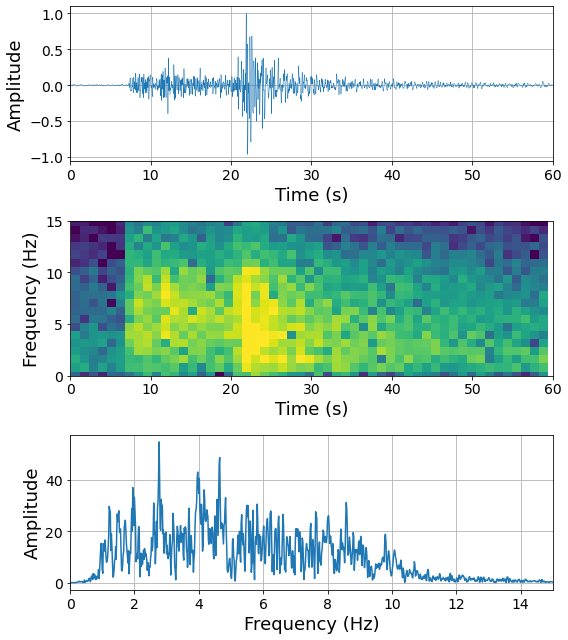

Plotting Explosion waveforms


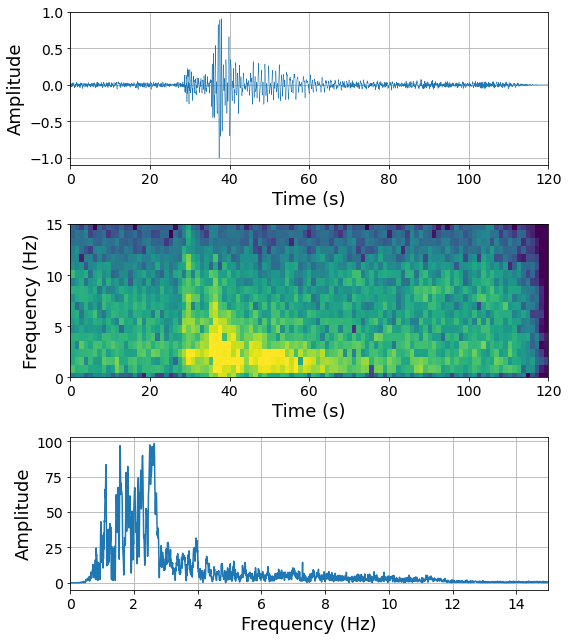

In [25]:
plot_event_information(norm_su[0], xlim = [60, 140], class_name = 'Surface Event')
plot_event_information(norm_no[0], xlim = [0, 150], class_name = 'Noise')
plot_event_information(norm_eq[0], xlim = [60, 120], class_name = 'Earthquake')
plot_event_information(norm_exp[23], xlim = [30, 150], class_name = 'Explosion')